# CS 505 Homework 06:  Transformers

## Problem Three

See the problem one notebook for details on due date, submission, etc.

As with problems one and two , there is an extensive tutorial section, followed by
some tasks at the end you need to complete.

#### Full Disclosure:  This is based on  Rey Farhan's post:

(https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)


# Introduction

In this problem, we will learn about fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data.

We start with a simplified script for fine-tuning GPT-2, and at the end,
your task will be to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting.


# Setup

In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

# Create Training Set


In [4]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'")
filename = 'Jane_Eyre.txt'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [5]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

cp: cannot stat '/content/gdrive/My Drive/Jane_Eyre.txt': No such file or directory


In [6]:
f=open(filename)
docs=f.readlines()
docs=[b.strip() for b in docs]
docs[:10]

['There was no possibility of taking a walk that day. We had been',
 'wandering, indeed, in the leafless shrubbery an hour in the morning;',
 'but since dinner (Mrs. Reed, when there was no company, dined early)',
 'the cold winter wind had brought with it clouds so sombre, and a rain',
 'so penetrating, that further outdoor exercise was now out of the',
 'question.',
 '',
 'I was glad of it: I never liked long walks, especially on chilly',
 'afternoons: dreadful to me was the coming home in the raw twilight,',
 'with nipped fingers and toes, and a heart saddened by the chidings of']

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-7-0dc1d487ac7d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

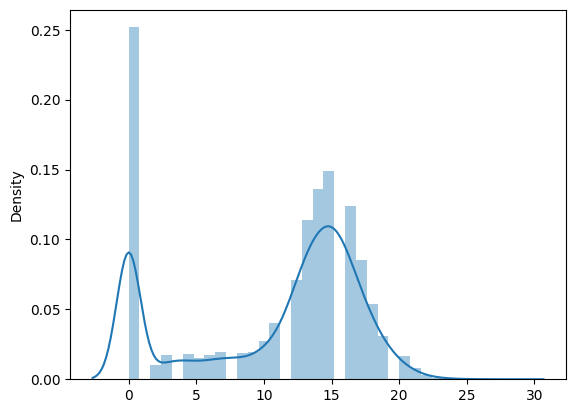

In [7]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [8]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [9]:
np.average(doc_lengths)

10.867097458648791

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [10]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [12]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [13]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [14]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,663 training samples
2,074 validation samples


In [15]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [26]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training parameters
epochs = 5
learning_rate = 3e-5  # Adjusted learning rate
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [28]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [29]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [30]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()
        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss
        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            model.train()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,332. Loss: 0.0737159252166748.   Elapsed: 0:00:16.
0:  bipartisan the the the the the the the the the
 the the
 the the the the the
 the the the the



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,332. Loss: 0.19848081469535828.   Elapsed: 0:00:33.
0:  increasing more
, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a. a, a, a, a,, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,332. Loss: 0.011245456524193287.   Elapsed: 0:00:51.
0: day. the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,332. Loss: 0.15093857049942017.   Elapsed: 0:01:07.
0:  Hang: (re: [re] [re] [re] [re] [re]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,332. Loss: 0.06372593343257904.   Elapsed: 0:01:23.
0:  foods., the one of me, when I was being kept from my friends, where I grew myself off.I remember a man who was looking at me, he had two, when I was looking at him, he had two.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,332. Loss: 0.11693485826253891.   Elapsed: 0:01:39.
0:  trail is have had who, he, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who, who,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,332. Loss: 0.13824009895324707.   Elapsed: 0:01:57.
0: intendm. A woman who. be, nor came down with him: nor fell at him as one: a stranger is not to be in the world: she that, I have made.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,332. Loss: 0.11051750928163528.   Elapsed: 0:02:13.
0:  surround


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,332. Loss: 0.06703124195337296.   Elapsed: 0:02:29.
0:  reflexin their own way? That I am not obliged to do me well at, I desire you to understand it. I know that I ought to kiss you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,332. Loss: 0.08229746669530869.   Elapsed: 0:02:45.
0:  displayb of this morning.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,332. Loss: 0.06095448508858681.   Elapsed: 0:03:00.
0:  pastor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,332. Loss: 0.08107051253318787.   Elapsed: 0:03:16.
0:  illicit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,332. Loss: 0.11973542720079422.   Elapsed: 0:03:32.
0:  Liberationby a little child by himself


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,332. Loss: 0.030834101140499115.   Elapsed: 0:03:47.
0:  Nam, the wind, which is the wind;—”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,332. Loss: 0.003049321938306093.   Elapsed: 0:04:03.
0: ION“A few miles away, “I was going to be—a few years ago I was—my first acquaintance—me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,332. Loss: 0.06834740191698074.   Elapsed: 0:04:19.
0:  glimpse


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,332. Loss: 0.005385268479585648.   Elapsed: 0:04:34.
0:  Laurebaked at her aunt,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,332. Loss: 0.05783364921808243.   Elapsed: 0:04:50.
0: ismin his very eyes, I thought at length that it was very silly to look at the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,332. Loss: 0.05712122842669487.   Elapsed: 0:05:06.
0: oun


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,332. Loss: 0.06497855484485626.   Elapsed: 0:05:21.
0:  election


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,332. Loss: 0.14215710759162903.   Elapsed: 0:05:37.
0:  crazyfetching in their pockets,—my cheeks were ruddy; and the curls were stilled; and the curls were still, I thought;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,332. Loss: 0.09463269263505936.   Elapsed: 0:05:53.
0:  bench


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,332. Loss: 0.003279811004176736.   Elapsed: 0:06:08.
0:  incorporated to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,332. Loss: 0.0833912193775177.   Elapsed: 0:06:25.
0: Peterin her cloak


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,332. Loss: 0.058084141463041306.   Elapsed: 0:06:40.
0: uring


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,332. Loss: 0.06345721334218979.   Elapsed: 0:06:56.
0:  reproductive


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,332. Loss: 0.11416375637054443.   Elapsed: 0:07:12.
0:  zonewith a little help from what he had; and that was when he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,332. Loss: 0.05148182809352875.   Elapsed: 0:07:27.
0:  commits


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,332. Loss: 0.05633622407913208.   Elapsed: 0:07:43.
0:  irony


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,332. Loss: 0.10425101220607758.   Elapsed: 0:07:58.
0:  Sahmah, was now ready to enter the gallery.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,332. Loss: 0.06594227254390717.   Elapsed: 0:08:14.
0:  BryanThe first chapter is a tale of the soul of a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,332. Loss: 0.11215943843126297.   Elapsed: 0:08:30.
0:  spirits


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,332. Loss: 0.11572564393281937.   Elapsed: 0:08:45.
0:  sees


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,332. Loss: 0.09647707641124725.   Elapsed: 0:09:01.
0:  hungry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,332. Loss: 0.04556329548358917.   Elapsed: 0:09:17.
0:  PTand: she was going to ask for what I was doing, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,332. Loss: 0.05382751300930977.   Elapsed: 0:09:32.
0: ümy mother, her auntie” said I, as I had made the same observation, “p. erewood that she ought to follow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,332. Loss: 0.08252393454313278.   Elapsed: 0:09:48.
0: ruce


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,332. Loss: 0.0520738810300827.   Elapsed: 0:10:04.
0:  derivativesa great deal more than I could bear—I had made a great deal of. I should


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,332. Loss: 0.08915595710277557.   Elapsed: 0:10:20.
0: with the aid of a woman. I turned to him—”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,332. Loss: 0.002805169904604554.   Elapsed: 0:10:35.
0:  remembering“I would like to put this in my pocket; or, if it came, of course, I would ask


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,332. Loss: 0.04857007786631584.   Elapsed: 0:10:51.
0:  Sources“Yes, I thought; but, as you have


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,332. Loss: 0.10065199434757233.   Elapsed: 0:11:07.
0: emsthe thing in the hall. “It must be—I can see it—that is what she is;” I said,”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,332. Loss: 0.05102972313761711.   Elapsed: 0:11:23.
0: tzd, with great joy and joy, and seemed as you now saw me when the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,332. Loss: 0.03391845151782036.   Elapsed: 0:11:38.
0: matic“Now you will be free tofeel the power of its power in me,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,332. Loss: 0.07856807857751846.   Elapsed: 0:11:54.
0:  syndin the neighbourhood—in the city, in the village


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,332. Loss: 0.02934654802083969.   Elapsed: 0:12:10.
0:  gam“It is not.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,332. Loss: 0.130615696310997.   Elapsed: 0:12:26.
0:  injury“Of Mr. Oliver, “I could tell from him a remarkable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,332. Loss: 0.06195678934454918.   Elapsed: 0:12:41.
0: azaof India; we had a quiet hour at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,332. Loss: 0.09263399243354797.   Elapsed: 0:12:57.
0:  membranea little, but when there are none, we will make an effort to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,332. Loss: 0.03040364384651184.   Elapsed: 0:13:13.
0: ijing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,332. Loss: 0.1053672730922699.   Elapsed: 0:13:28.
0:  castI would go and get the picture of a picture by a handsome young lady of Mr. Rochester, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,332. Loss: 0.06680403649806976.   Elapsed: 0:13:44.
0:  purch“He was a long time past our time; he had come to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,332. Loss: 0.08244391530752182.   Elapsed: 0:14:00.
0:  shoulders“Good night, Mrs. Ingram; thank you for your advice.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,332. Loss: 0.07775013148784637.   Elapsed: 0:14:16.
0:  built“Jane! You are just a child, Jane.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,332. Loss: 0.04726877436041832.   Elapsed: 0:14:31.
0:  openly


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,332. Loss: 0.10426072776317596.   Elapsed: 0:14:47.
0:  halted“Well, you say, you must be of use to me, Mr. Rochester


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,332. Loss: 0.05196560174226761.   Elapsed: 0:15:03.
0:  Nikit, and I thought he knew nothing of my own


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,332. Loss: 0.03850362077355385.   Elapsed: 0:15:18.
0:  tinand as well as the other women who had come in; I took one of the cups and, with an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,332. Loss: 0.1183559000492096.   Elapsed: 0:15:34.
0:  clinicalyou had heard of this great show: it was an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,332. Loss: 0.09154590219259262.   Elapsed: 0:15:50.
0: lections“How much longer shall I be on the sofa, then?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,332. Loss: 0.09419742971658707.   Elapsed: 0:16:06.
0: elsfor them to have got up with me. To make a return we passed at last to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,332. Loss: 0.03074890747666359.   Elapsed: 0:16:22.
0: laband he answered, “Jane,” continued he, “that you are ill-treated and oppressed.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,332. Loss: 0.05424288660287857.   Elapsed: 0:16:37.
0:  tripleto give the ladies an opportunity of taking a new


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,332. Loss: 0.12044180929660797.   Elapsed: 0:16:53.
0: 220“It has been so: your own will, you have become so much more


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,332. Loss: 0.05486397072672844.   Elapsed: 0:17:09.
0:  See


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,332. Loss: 0.09182772785425186.   Elapsed: 0:17:24.
0: @@to the end. As she said so, a voice broke


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,332. Loss: 0.053968485444784164.   Elapsed: 0:17:40.
0:  hostdoubt of being able to accept it at once.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,332. Loss: 0.0959407389163971.   Elapsed: 0:17:56.
0: role


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,332. Loss: 0.07626711577177048.   Elapsed: 0:18:11.
0: iac“Do you remember, my dear?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,332. Loss: 0.04811333492398262.   Elapsed: 0:18:27.
0:  LD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,332. Loss: 0.08504829555749893.   Elapsed: 0:18:43.
0:  Listen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,332. Loss: 0.08143056929111481.   Elapsed: 0:18:58.
0:  dy“You’ve got a new book.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,332. Loss: 0.08601807802915573.   Elapsed: 0:19:14.
0:  Domestic


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,332. Loss: 0.06627583503723145.   Elapsed: 0:19:30.
0:  beneficiaries


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,332. Loss: 0.07736189663410187.   Elapsed: 0:19:45.
0:  Titledear, your prayers are sincere: but your prayers, though sincere, do not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,332. Loss: 0.05815349146723747.   Elapsed: 0:20:01.
0:  μ


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,332. Loss: 0.05622357875108719.   Elapsed: 0:20:16.
0:  selling“Will you let me to get any more,” she asked, as he asked, “when I have an hour?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,332. Loss: 0.07635516673326492.   Elapsed: 0:20:32.
0:  migrant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,332. Loss: 0.0963079035282135.   Elapsed: 0:20:48.
0: ivelyfurniture for them, and for me the only means I have to get them


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,332. Loss: 0.018711840733885765.   Elapsed: 0:21:04.
0:  order“Sir?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,332. Loss: 0.08837264031171799.   Elapsed: 0:21:19.
0:  VPN


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,332. Loss: 0.07807467877864838.   Elapsed: 0:21:35.
0:  explanation


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,332. Loss: 0.061124131083488464.   Elapsed: 0:21:50.
0:  Bachand her mother; and all this was done with good faith, with earnest,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,332. Loss: 0.09870259463787079.   Elapsed: 0:22:06.
0:  folder


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,332. Loss: 0.09066525846719742.   Elapsed: 0:22:22.
0:  building“Not much of him. I shall be glad.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,332. Loss: 0.09329421818256378.   Elapsed: 0:22:38.
0:  Babylon


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,332. Loss: 0.05093070864677429.   Elapsed: 0:22:53.
0: perial“My wife is so fond of all those who serve her as a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,332. Loss: 0.12224681675434113.   Elapsed: 0:23:09.
0:  rents“Yes; he says that—I cannot tell him; but I have done something; and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,332. Loss: 0.002177744871005416.   Elapsed: 0:23:25.
0:  Reg“I did have a very strange thought before I fell asleep.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,332. Loss: 0.08435744792222977.   Elapsed: 0:23:40.
0: olas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,332. Loss: 0.13083407282829285.   Elapsed: 0:23:56.
0:  responses“And so you are indeed—”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,332. Loss: 0.0957794114947319.   Elapsed: 0:24:12.
0:  attendance“No, I am quite at it—I have no interest in it,” said Mrs. Fairfax, “and, for me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,332. Loss: 0.11393455415964127.   Elapsed: 0:24:28.
0:  rigidand then came down with the same abrupt and unspeakable shock of his heart

  Average training loss: 0.09
  Training epoch took: 0:24:33

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:51

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,332. Loss: 0.11174248158931732.   Elapsed: 0:00:16.
0: gro“My sister is dead;” and so I told her not to turn to me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,332. Loss: 0.07790457457304001.   Elapsed: 0:00:31.
0:  Gre


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,332. Loss: 0.04765656962990761.   Elapsed: 0:00:47.
0: ura“I am in need of employment, sir; I could not help it at all.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,332. Loss: 0.0856107771396637.   Elapsed: 0:01:03.
0:  2020“I will tell you, Miss, that I have been in England a long time. I knew


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,332. Loss: 0.06540212035179138.   Elapsed: 0:01:19.
0:  chargingand then I went out into the open to meet the ladies: at least four


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,332. Loss: 0.07285799086093903.   Elapsed: 0:01:34.
0:  Sar


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,332. Loss: 0.04996553808450699.   Elapsed: 0:01:50.
0:  Jas


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,332. Loss: 0.03444613516330719.   Elapsed: 0:02:05.
0:  permit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,332. Loss: 0.05722494050860405.   Elapsed: 0:02:21.
0:  Administrator


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,332. Loss: 0.08963628113269806.   Elapsed: 0:02:37.
0:  EVENTSfurther into the church, as soon as you see the bell ringing, and you are within the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,332. Loss: 0.0876956358551979.   Elapsed: 0:02:52.
0:  Mental“This is where you stay at the present-day cottage.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,332. Loss: 0.10521658509969711.   Elapsed: 0:03:08.
0: ids“Where do you like a meal, Miss?—”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,332. Loss: 0.09074652194976807.   Elapsed: 0:03:24.
0: ceans


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,332. Loss: 0.05449608713388443.   Elapsed: 0:03:39.
0:  geneticallyof the poor person, with his eyes, the lips, and hair;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,332. Loss: 0.08567144721746445.   Elapsed: 0:03:55.
0:  advice


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,332. Loss: 0.038926683366298676.   Elapsed: 0:04:11.
0:  incompleteand this is the way we will commence.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,332. Loss: 0.0994710624217987.   Elapsed: 0:04:26.
0: comment


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,332. Loss: 0.08701981604099274.   Elapsed: 0:04:42.
0:  pilotsisters are at school; and to put them into bed is a great deal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,332. Loss: 0.08739464730024338.   Elapsed: 0:04:58.
0: gers“Yes, you are a very pleasant man,” continued Mr. Rochester.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,332. Loss: 0.08898177742958069.   Elapsed: 0:05:14.
0:  mutationmeantime, I felt a sudden and almost sudden pleasure in feeling you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,332. Loss: 0.0033290849532932043.   Elapsed: 0:05:29.
0:  Driverand the other ladies—to whom he gave the order. The Colonel looked at me:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,332. Loss: 0.03719572722911835.   Elapsed: 0:05:45.
0: iti


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,332. Loss: 0.07898815721273422.   Elapsed: 0:06:01.
0: fff


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,332. Loss: 0.0992758497595787.   Elapsed: 0:06:16.
0: riminationin his heart, though only his voice was hushed: he was not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,332. Loss: 0.04697341471910477.   Elapsed: 0:06:32.
0: aqueto the great sea. As much a buoyant breeze, as so much a watery gulf.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,332. Loss: 0.07174120843410492.   Elapsed: 0:06:48.
0: lee


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,332. Loss: 0.003281950717791915.   Elapsed: 0:07:03.
0:  Alzheimer“Don’t you believe in her? You’re not ignorant of her name?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,332. Loss: 0.0020811092108488083.   Elapsed: 0:07:19.
0:  checking“Yes.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,332. Loss: 0.10412164777517319.   Elapsed: 0:07:35.
0: nesium


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,332. Loss: 0.10714513063430786.   Elapsed: 0:07:50.
0:  1957“Indeed, my own character and manner is no more so than his. He never


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,332. Loss: 0.07444462925195694.   Elapsed: 0:08:06.
0: manship“Very well! You are the best of children—I must say I cannot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,332. Loss: 0.07019205391407013.   Elapsed: 0:08:22.
0:  understandI should not be too much surprised; it is not so far from being a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,332. Loss: 0.0662924274802208.   Elapsed: 0:08:38.
0:  passion“No, sir: you never know where she is!”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,332. Loss: 0.07121706753969193.   Elapsed: 0:08:53.
0:  curvedthe bedstead, and a fire lit the chimney in the kitchen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,332. Loss: 0.09052831679582596.   Elapsed: 0:09:09.
0:  An


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,332. Loss: 0.06074516847729683.   Elapsed: 0:09:25.
0: otti“It is not like the last time I saw John Fairfax, it is not like his


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,332. Loss: 0.0669378861784935.   Elapsed: 0:09:40.
0:  intake


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,332. Loss: 0.057750407606363297.   Elapsed: 0:09:56.
0:  Tsshe’s got nothing on the earth. No one knows the circumstances of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,332. Loss: 0.06252596527338028.   Elapsed: 0:10:12.
0:  Main


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,332. Loss: 0.08985783159732819.   Elapsed: 0:10:27.
0:  tem


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,332. Loss: 0.045501530170440674.   Elapsed: 0:10:43.
0:  Click“Is she an ordinary young girl?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,332. Loss: 0.09612277895212173.   Elapsed: 0:10:59.
0:  XV“I will do my best to help you.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,332. Loss: 0.04696820303797722.   Elapsed: 0:11:14.
0:  dorm“Jane, come to the little room you are to find your own furniture: let me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,332. Loss: 0.04268043860793114.   Elapsed: 0:11:30.
0:  upstreamhe who pays what you will for.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,332. Loss: 0.10367913544178009.   Elapsed: 0:11:46.
0: ال“And do you think she is poor?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,332. Loss: 0.04566691815853119.   Elapsed: 0:12:02.
0: aria


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,332. Loss: 0.07969232648611069.   Elapsed: 0:12:17.
0: PG“Mr. Brocklehurst, sir,” said I, “he is very strange, and I believe


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,332. Loss: 0.07364846765995026.   Elapsed: 0:12:33.
0: Ill“She is well, sir: I want her to do me the favour.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,332. Loss: 0.06317394226789474.   Elapsed: 0:12:49.
0:  automated“And then she left me? How did she forget her friends?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,332. Loss: 0.011139786802232265.   Elapsed: 0:13:05.
0:  hiring“Yes, it would be dangerous and impossible to live. You are in the wrong: but I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,332. Loss: 0.0846477746963501.   Elapsed: 0:13:20.
0:  tweeting


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,332. Loss: 0.010880514979362488.   Elapsed: 0:13:36.
0: abitto be regarded as such as one could possibly be: but one could be regarded as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,332. Loss: 0.0013204892165958881.   Elapsed: 0:13:52.
0:  ii


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,332. Loss: 0.002167539205402136.   Elapsed: 0:14:07.
0: clip


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,332. Loss: 0.0416625440120697.   Elapsed: 0:14:23.
0:  Franc


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,332. Loss: 0.04698273167014122.   Elapsed: 0:14:38.
0:  listeningwas very pleasant. But I would not have the time to be too


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,332. Loss: 0.03685809671878815.   Elapsed: 0:14:54.
0:  EU


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,332. Loss: 0.08434384316205978.   Elapsed: 0:15:10.
0:  incredibleI was now in my room, and as I was about to leave, as she put off the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,332. Loss: 0.025384441018104553.   Elapsed: 0:15:25.
0:  TY“It is Miss Fairfax,” he said; “she is a woman! Why are she


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,332. Loss: 0.08087481558322906.   Elapsed: 0:15:41.
0:  230Reed stood tall, and then seated: he stood tall; his face was large, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,332. Loss: 0.05929088592529297.   Elapsed: 0:15:57.
0:  Tigers


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,332. Loss: 0.029194127768278122.   Elapsed: 0:16:13.
0: CD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,332. Loss: 0.10573749989271164.   Elapsed: 0:16:28.
0:  unbelievable“A little while: let the children come back for a walk; I will give them


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,332. Loss: 0.09099073708057404.   Elapsed: 0:16:44.
0: Robert“You will hear, Jane, that the two gentlemen are in this room when they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,332. Loss: 0.061151254922151566.   Elapsed: 0:17:00.
0:  Contact


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,332. Loss: 0.06445571035146713.   Elapsed: 0:17:15.
0:  fountainpapa?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,332. Loss: 0.01540488563477993.   Elapsed: 0:17:31.
0:  clashhis voice was cold, hard: there was a low voice, which, in that case,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,332. Loss: 0.0022350347135215998.   Elapsed: 0:17:47.
0:  commod“A kind of cold air from where I had been sleeping, and a cold wind blowing from


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,332. Loss: 0.08459766954183578.   Elapsed: 0:18:02.
0:  algorithm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,332. Loss: 0.07897616922855377.   Elapsed: 0:18:18.
0:  accurateHe paused. I had heard a voice from upstairs, and heard Mr. Rochester talking


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,332. Loss: 0.047866616398096085.   Elapsed: 0:18:34.
0: ado


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,332. Loss: 0.03571494296193123.   Elapsed: 0:18:49.
0:  regulate


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,332. Loss: 0.05743525177240372.   Elapsed: 0:19:05.
0: eway


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,332. Loss: 0.043107811361551285.   Elapsed: 0:19:20.
0: itteeand a cloak that had been worn with a shawl on it—her shoes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,332. Loss: 0.052644770592451096.   Elapsed: 0:19:36.
0:  Jackie


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,332. Loss: 0.061404261738061905.   Elapsed: 0:19:52.
0: Hestray, so quietly that a man may appear behind them,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,332. Loss: 0.10214333981275558.   Elapsed: 0:20:07.
0:  wired


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,332. Loss: 0.09925061464309692.   Elapsed: 0:20:23.
0:  frequ“We are on your side; we are at your side.” And I went to the door.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,332. Loss: 0.09233061224222183.   Elapsed: 0:20:39.
0:  views“She could have been useful.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,332. Loss: 0.09076400846242905.   Elapsed: 0:20:54.
0:  Strategy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,332. Loss: 0.10719162970781326.   Elapsed: 0:21:10.
0:  radio


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,332. Loss: 0.09639081358909607.   Elapsed: 0:21:26.
0: oult“Is it necessary I am to take the necessary course of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,332. Loss: 0.042437463998794556.   Elapsed: 0:21:41.
0:  Rein


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,332. Loss: 0.001742429449222982.   Elapsed: 0:21:57.
0:  procgates open in some great-grandeur in the city: I wish it could go


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,332. Loss: 0.08032527565956116.   Elapsed: 0:22:13.
0:  abuseshis name—or not:—he is a stranger to me: I have heard him


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,332. Loss: 0.11122184246778488.   Elapsed: 0:22:28.
0:  wa


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,332. Loss: 0.09983057528734207.   Elapsed: 0:22:44.
0: lectedthat I should not be able to secure by any other means,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,332. Loss: 0.04447183012962341.   Elapsed: 0:23:00.
0:  temple


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,332. Loss: 0.028977226465940475.   Elapsed: 0:23:15.
0:  lod“I heard all the clergymen speak, and all the ladies, ladies, were


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,332. Loss: 0.06641411781311035.   Elapsed: 0:23:31.
0:  Rio“It is all right.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,332. Loss: 0.08915288746356964.   Elapsed: 0:23:47.
0:  Pence


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,332. Loss: 0.06325998157262802.   Elapsed: 0:24:02.
0:  Steven


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,332. Loss: 0.06292419135570526.   Elapsed: 0:24:18.
0:  discourse“I suppose you are an orphan, Adela? I was not aware that

  Average training loss: 0.07
  Training epoch took: 0:24:23

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:51

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,332. Loss: 0.0766654908657074.   Elapsed: 0:00:16.
0:  accessory“But then Miss Oliver is dead, I suppose?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,332. Loss: 0.047001905739307404.   Elapsed: 0:00:31.
0: ul“It looks like Mr. Rochester would like me to stay with him.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,332. Loss: 0.04292090982198715.   Elapsed: 0:00:47.
0:  slidingit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,332. Loss: 0.05603115260601044.   Elapsed: 0:01:03.
0:  Dell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,332. Loss: 0.03448138386011124.   Elapsed: 0:01:18.
0: ius“Then you must be Mr. Poole’s wife,” she responded.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,332. Loss: 0.0433790348470211.   Elapsed: 0:01:34.
0: sided


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,332. Loss: 0.06485533714294434.   Elapsed: 0:01:50.
0:  WP“Oh, I shall make you a little rich.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,332. Loss: 0.04654203727841377.   Elapsed: 0:02:05.
0:  exertI have made it my duty to keep her from getting into difficulties, and to keep


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,332. Loss: 0.05778280273079872.   Elapsed: 0:02:21.
0: inian


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,332. Loss: 0.07051125168800354.   Elapsed: 0:02:37.
0:  electricity


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,332. Loss: 0.04368462413549423.   Elapsed: 0:02:52.
0:  Aviation


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,332. Loss: 0.07628645747900009.   Elapsed: 0:03:08.
0:  encodingyour nature with a sort of pity and sympathy, and a deep


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,332. Loss: 0.07203713804483414.   Elapsed: 0:03:23.
0: fit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,332. Loss: 0.046580106019973755.   Elapsed: 0:03:39.
0:  wife“It is not likely to him—it is probably impossible, sir.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,332. Loss: 0.025938276201486588.   Elapsed: 0:03:55.
0: ileyme, but I cannot tell; and when my solicitor asks me to sign a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,332. Loss: 0.032449398189783096.   Elapsed: 0:04:11.
0: stagein the room, and with him again to the toilet, and the other to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,332. Loss: 0.08334587514400482.   Elapsed: 0:04:26.
0: hat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,332. Loss: 0.09192559868097305.   Elapsed: 0:04:42.
0: Richwatched all the tumult: she looked at me as if I had seen a ghost.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,332. Loss: 0.022514306008815765.   Elapsed: 0:04:58.
0: �


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,332. Loss: 0.08280100673437119.   Elapsed: 0:05:13.
0:  pretendingof you, Jane?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,332. Loss: 0.058946870267391205.   Elapsed: 0:05:29.
0:  PCBand all manner of furniture, to keep you at his side as he had


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,332. Loss: 0.0020376190077513456.   Elapsed: 0:05:45.
0:  retrospecthad been of no use; and if anything ever happened to her, it was to go


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,332. Loss: 0.026555519551038742.   Elapsed: 0:06:00.
0:  plain“I have given you my word that you never must be trusted. I have put you off


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,332. Loss: 0.08843056112527847.   Elapsed: 0:06:16.
0:  disclosedin the evening I returned to him. Mrs. Fairfax was a very hard woman; a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,332. Loss: 0.0249966848641634.   Elapsed: 0:06:32.
0:  beverage“And do you like her?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,332. Loss: 0.051855362951755524.   Elapsed: 0:06:48.
0:  ("not like myself. I like you, I thought.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,332. Loss: 0.09647312760353088.   Elapsed: 0:07:03.
0:  founding


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,332. Loss: 0.0829210877418518.   Elapsed: 0:07:19.
0:  filesystemThe room was soon dark; Mr. Rochester was now out of his usual


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,332. Loss: 0.08416600525379181.   Elapsed: 0:07:35.
0:  normal“I cannot tell.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,332. Loss: 0.04064532741904259.   Elapsed: 0:07:50.
0:  Martial“I would never do that.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,332. Loss: 0.04734603315591812.   Elapsed: 0:08:06.
0: Human“No, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,332. Loss: 0.04114430397748947.   Elapsed: 0:08:21.
0:  discount“Good evening.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,332. Loss: 0.07872075587511063.   Elapsed: 0:08:37.
0:  frontier“Well?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,332. Loss: 0.08253957331180573.   Elapsed: 0:08:53.
0:  atmospheric


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,332. Loss: 0.05203092470765114.   Elapsed: 0:09:08.
0:  foundingdrew, had been to speak to the servant a few minutes before: he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,332. Loss: 0.05476447939872742.   Elapsed: 0:09:24.
0:  medievalher, and she has been looking for you ever since.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,332. Loss: 0.0680796429514885.   Elapsed: 0:09:40.
0:  channelRochester has done no wrong to her: you are wrong in your attitude to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,332. Loss: 0.0967170000076294.   Elapsed: 0:09:56.
0:  views


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,332. Loss: 0.07799789309501648.   Elapsed: 0:10:11.
0:  revolutionary“Mr. Rochester!”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,332. Loss: 0.04633403941988945.   Elapsed: 0:10:27.
0:  interactingtroubled! How dare he break my heart and repress my hope of an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,332. Loss: 0.03735829144716263.   Elapsed: 0:10:42.
0:  subsc


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,332. Loss: 0.08787384629249573.   Elapsed: 0:10:58.
0:  remainderthe morning was too quiet to permit you to enter the schoolroom; I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,332. Loss: 0.0020185464527457952.   Elapsed: 0:11:14.
0: Say


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,332. Loss: 0.04121605306863785.   Elapsed: 0:11:29.
0:  jarfor the time being, I knew nothing about her: I had only


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,332. Loss: 0.057999804615974426.   Elapsed: 0:11:45.
0: 4I think the word was never too strange to me: it may have been


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,332. Loss: 0.08832518011331558.   Elapsed: 0:12:01.
0:  Jeffrey“My good Jane,” said Bessie, “it will be all right.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,332. Loss: 0.08425846695899963.   Elapsed: 0:12:17.
0:  corrupt


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,332. Loss: 0.03841927647590637.   Elapsed: 0:12:32.
0:  mistakenHe drew near, and my pale-faced eye gleamed over the gleaming


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,332. Loss: 0.04524364322423935.   Elapsed: 0:12:48.
0:  becthe most vivid of her eyes. A black and shining eye gleams round her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,332. Loss: 0.05658678337931633.   Elapsed: 0:13:04.
0: Mymyself—so—so poor!”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,332. Loss: 0.045939259231090546.   Elapsed: 0:13:19.
0:  FO


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,332. Loss: 0.07615183293819427.   Elapsed: 0:13:35.
0: qqato the moon. What he did with the body of the orphan was still unknown


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,332. Loss: 0.07649081945419312.   Elapsed: 0:13:51.
0:  206“You are not like this, Mr. Lloyd. It is as I said: you are not like


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,332. Loss: 0.0319538451731205.   Elapsed: 0:14:06.
0: Simple


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,332. Loss: 0.09488778561353683.   Elapsed: 0:14:22.
0:  Hur“No.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,332. Loss: 0.002303504617884755.   Elapsed: 0:14:38.
0:  murdit to be brought up again by my parents. I left them with their


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,332. Loss: 0.03724237531423569.   Elapsed: 0:14:53.
0: 60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,332. Loss: 0.05068653076887131.   Elapsed: 0:15:09.
0:  asks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,332. Loss: 0.04641158506274223.   Elapsed: 0:15:24.
0: 399“You should see, my sweetheart! Yes, you should hear me distinctly:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,332. Loss: 0.08585714548826218.   Elapsed: 0:15:40.
0:  Sunni“Did you feel that way?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,332. Loss: 0.07058683037757874.   Elapsed: 0:15:56.
0:  requestsister, I saw her standing alone at the other end of the table,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,332. Loss: 0.0710991695523262.   Elapsed: 0:16:12.
0:  China“And who is there?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,332. Loss: 0.08580566197633743.   Elapsed: 0:16:27.
0: "></


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,332. Loss: 0.11241956800222397.   Elapsed: 0:16:43.
0:  midst“Yes, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,332. Loss: 0.09188121557235718.   Elapsed: 0:16:59.
0:  Constitutional


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,332. Loss: 0.047055743634700775.   Elapsed: 0:17:14.
0: vironaspect in our minds: what we want to see is visible. I had much


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,332. Loss: 0.09769483655691147.   Elapsed: 0:17:30.
0:  blo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,332. Loss: 0.06140515208244324.   Elapsed: 0:17:45.
0:  Chile“I should not have been glad at the present time to be at home with


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,332. Loss: 0.0948839858174324.   Elapsed: 0:18:01.
0: Knyou must make it very well.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,332. Loss: 0.06900869309902191.   Elapsed: 0:18:17.
0: yan“Miss Oliver and the ladies are coming!”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,332. Loss: 0.047574233263731.   Elapsed: 0:18:33.
0:  exerc“He did me well; he was not his usual self, but his usual and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,332. Loss: 0.08216223120689392.   Elapsed: 0:18:48.
0:  mystand a good man—a good man, and perhaps even a good man, who would in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,332. Loss: 0.05225575715303421.   Elapsed: 0:19:04.
0:  puzz


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,332. Loss: 0.07343187183141708.   Elapsed: 0:19:20.
0:  morality“Well, you’ll probably be happy here. There may well be good business


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,332. Loss: 0.013006603345274925.   Elapsed: 0:19:36.
0: aniasir,” I replied; “it is not a new thing. It has been my custom—I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,332. Loss: 0.05173759534955025.   Elapsed: 0:19:51.
0:  assigned


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,332. Loss: 0.0018609913531690836.   Elapsed: 0:20:07.
0:  sometime“You have, Miss, nothing to do.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,332. Loss: 0.09098421037197113.   Elapsed: 0:20:23.
0: ewitnessto a new and happy home in their own, where I will be prepared for an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,332. Loss: 0.04429477080702782.   Elapsed: 0:20:38.
0:  coordination


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,332. Loss: 0.040232203900814056.   Elapsed: 0:20:54.
0: bage“I love you, I will do every good; and I am proud of it. And I have,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,332. Loss: 0.05422736331820488.   Elapsed: 0:21:10.
0:  mo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,332. Loss: 0.06430153548717499.   Elapsed: 0:21:25.
0:  1965to me?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,332. Loss: 0.08751663565635681.   Elapsed: 0:21:41.
0: Business“It may not come; but I can do it.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,332. Loss: 0.05401597544550896.   Elapsed: 0:21:57.
0: CryptHe proceeded, with that earnestness, through the library: at last we


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,332. Loss: 0.04298483580350876.   Elapsed: 0:22:13.
0: male


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,332. Loss: 0.08318968117237091.   Elapsed: 0:22:28.
0: ja


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,332. Loss: 0.03373067080974579.   Elapsed: 0:22:44.
0: 189“Yes. “And I have a good plan: to be the judge of your


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,332. Loss: 0.05871748551726341.   Elapsed: 0:22:59.
0: corthe field—the fields beyond and in the hallowed turf: what then?—


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,332. Loss: 0.05086778104305267.   Elapsed: 0:23:15.
0:  Jerry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,332. Loss: 0.07217922806739807.   Elapsed: 0:23:31.
0:  uraniumwas a small dwelling. The house itself was surrounded by the great oak and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,332. Loss: 0.08812126517295837.   Elapsed: 0:23:46.
0:  ironyI left him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,332. Loss: 0.043940357863903046.   Elapsed: 0:24:02.
0: ″


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,332. Loss: 0.06948880106210709.   Elapsed: 0:24:18.
0:  AWshe went, she walked into the kitchen; she left me in a chair and

  Average training loss: 0.06
  Training epoch took: 0:24:23

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:51

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,332. Loss: 0.03653490170836449.   Elapsed: 0:00:16.
0:  Renewthe first lesson of the school: I heard of it at school; in one of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,332. Loss: 0.028932247310876846.   Elapsed: 0:00:31.
0: GP


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,332. Loss: 0.08466233313083649.   Elapsed: 0:00:47.
0: uv


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,332. Loss: 0.05591964349150658.   Elapsed: 0:01:02.
0:  Ohthe last of the old-fashioned associations of marriage, which, once secured,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,332. Loss: 0.08520303666591644.   Elapsed: 0:01:18.
0:  Carl“Well, Miss?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,332. Loss: 0.08237344771623611.   Elapsed: 0:01:34.
0:  lies


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,332. Loss: 0.04288351535797119.   Elapsed: 0:01:49.
0:  typethe room; and Mr. Rochester had his hand laid on my shoulder. He


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,332. Loss: 0.06641887128353119.   Elapsed: 0:02:05.
0:  Vice


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,332. Loss: 0.07743076235055923.   Elapsed: 0:02:21.
0: vers“Yes; for she is called Abbot, and when she was little, she got her


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,332. Loss: 0.09411926567554474.   Elapsed: 0:02:37.
0:  starkHe took it in, unclosed, and put it away, forgetting me. I thought


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,332. Loss: 0.016552934423089027.   Elapsed: 0:02:52.
0:  smartphonesnot look as you will.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,332. Loss: 0.022244997322559357.   Elapsed: 0:03:08.
0:  hotel“Do you have another idea of what is to come?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,332. Loss: 0.05133263021707535.   Elapsed: 0:03:24.
0:  unhappy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,332. Loss: 0.07908869534730911.   Elapsed: 0:03:39.
0: fastyou have seen, are you sure you are not?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,332. Loss: 0.037446096539497375.   Elapsed: 0:03:55.
0: �“No, no, sir! What! no!” he exclaimed. Then, having lifted my eyes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,332. Loss: 0.06725610047578812.   Elapsed: 0:04:11.
0: 35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,332. Loss: 0.05353672802448273.   Elapsed: 0:04:26.
0: 275“Not like, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,332. Loss: 0.024954939261078835.   Elapsed: 0:04:42.
0:  masks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,332. Loss: 0.036379873752593994.   Elapsed: 0:04:58.
0: posthe door of the nursery, she said a fairy had passed it and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,332. Loss: 0.06608311831951141.   Elapsed: 0:05:13.
0:  Linkand all my clothes, and a cloak which would not offend her. Missis would be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,332. Loss: 0.026990341022610664.   Elapsed: 0:05:29.
0:  addressHe did not look over my shoulder. “Oh, I knew you’d come to see me. I told you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,332. Loss: 0.08495645970106125.   Elapsed: 0:05:45.
0:  empoweredthe door. I approached it, expecting Mr. Rochester would come, but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,332. Loss: 0.07732538878917694.   Elapsed: 0:06:01.
0: gan“Yes, my dear child; he looks like the last of the Roman emperors.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,332. Loss: 0.054616592824459076.   Elapsed: 0:06:17.
0: ryceof my head.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,332. Loss: 0.05924542248249054.   Elapsed: 0:06:32.
0:  legislative“Yes.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,332. Loss: 0.07075202465057373.   Elapsed: 0:06:48.
0:  vol


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,332. Loss: 0.06019819155335426.   Elapsed: 0:07:03.
0: hranand the world. They say they may come back a moment sooner, perhaps,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,332. Loss: 0.0877523124217987.   Elapsed: 0:07:19.
0:  teachers“Why are there so few books about us?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,332. Loss: 0.08546528220176697.   Elapsed: 0:07:35.
0: Top“In another lifetime? Not far off.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,332. Loss: 0.03185923397541046.   Elapsed: 0:07:51.
0:  policing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,332. Loss: 0.06346851587295532.   Elapsed: 0:08:06.
0:  charts“How much do you intend to spend on this, Miss?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,332. Loss: 0.057085536420345306.   Elapsed: 0:08:22.
0:  blocks“No, nor I should think, sir, with those coarse features: they would be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,332. Loss: 0.041589077562093735.   Elapsed: 0:08:38.
0:  variantswas now filled with a large quantity of money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,332. Loss: 0.04493866488337517.   Elapsed: 0:08:53.
0:  fan“I suppose it is the old custom for us to send a shilling to Mr.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,332. Loss: 0.07568269222974777.   Elapsed: 0:09:09.
0:  FIR


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,332. Loss: 0.08307374268770218.   Elapsed: 0:09:25.
0: ctica“A mere beggar?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,332. Loss: 0.0769636482000351.   Elapsed: 0:09:40.
0: Small“It looks a change to you, Miss, that you are fond of: in short, you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,332. Loss: 0.03550615534186363.   Elapsed: 0:09:56.
0:  compos


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,332. Loss: 0.0820951759815216.   Elapsed: 0:10:12.
0:  bayto me.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,332. Loss: 0.08396994322538376.   Elapsed: 0:10:27.
0:  GTsunny, even though a portion of my salary was already paid: the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,332. Loss: 0.060546256601810455.   Elapsed: 0:10:43.
0:  pinnedbut not of being sent into danger, that the most excellent


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,332. Loss: 0.03151153773069382.   Elapsed: 0:10:59.
0:  triumph


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,332. Loss: 0.10479121655225754.   Elapsed: 0:11:14.
0:  Neptune“Are they married?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,332. Loss: 0.06776794791221619.   Elapsed: 0:11:30.
0:  purchases


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,332. Loss: 0.027697758749127388.   Elapsed: 0:11:46.
0:  professor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,332. Loss: 0.08728525042533875.   Elapsed: 0:12:01.
0:  box“I am not sure. It is likely she will be with Jane, and will be at the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,332. Loss: 0.08381682634353638.   Elapsed: 0:12:17.
0:  considered“Why did you leave my sisters in Madeira and Madeira?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,332. Loss: 0.04588506370782852.   Elapsed: 0:12:33.
0:  empirical


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,332. Loss: 0.06422550976276398.   Elapsed: 0:12:48.
0: unks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,332. Loss: 0.07294033467769623.   Elapsed: 0:13:04.
0: Orig


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,332. Loss: 0.035121675580739975.   Elapsed: 0:13:19.
0: oots


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,332. Loss: 0.0835447758436203.   Elapsed: 0:13:35.
0:  bombing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,332. Loss: 0.05159434303641319.   Elapsed: 0:13:51.
0:  variant“I was afraid of St. John; but then I will allow him my share:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,332. Loss: 0.08148490637540817.   Elapsed: 0:14:06.
0:  outfield


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,332. Loss: 0.01046681683510542.   Elapsed: 0:14:22.
0: otics


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,332. Loss: 0.09044932574033737.   Elapsed: 0:14:37.
0: );“I saw some of his drawings on a sofa by the window; so, having


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,332. Loss: 0.0993756353855133.   Elapsed: 0:14:53.
0: tmp


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,332. Loss: 0.05952721834182739.   Elapsed: 0:15:09.
0: angular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,332. Loss: 0.08316211402416229.   Elapsed: 0:15:24.
0: gow


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,332. Loss: 0.03859308734536171.   Elapsed: 0:15:40.
0: rol


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,332. Loss: 0.03417303413152695.   Elapsed: 0:15:55.
0:  24feared, too, an unusual feeling and a strange aversion. Still,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,332. Loss: 0.041942983865737915.   Elapsed: 0:16:11.
0: irable“You have a very bad appetite,” said Bessie, “but it is not your fault:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,332. Loss: 0.04319946840405464.   Elapsed: 0:16:27.
0:  allev“It is not your turn, sir—let him look at you. I shall not attempt to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,332. Loss: 0.03968849405646324.   Elapsed: 0:16:43.
0:  legallythe house, and the girls would sit alone, and the servants would go to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,332. Loss: 0.08346718549728394.   Elapsed: 0:16:59.
0:  spinal“Is he a handsome fellow?” she asked of the old master of Brocklehurst:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,332. Loss: 0.07304675132036209.   Elapsed: 0:17:14.
0:  loomingand my mind, as if it were a dream; and to this day I can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,332. Loss: 0.042988121509552.   Elapsed: 0:17:30.
0: •“Who the hell is that?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,332. Loss: 0.03777778893709183.   Elapsed: 0:17:46.
0:  respectivelypile of chairs near the window; my eyes turned to a large table;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,332. Loss: 0.002013848163187504.   Elapsed: 0:18:02.
0:  cloud“Sir, and did you like the fire, Helen?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,332. Loss: 0.09032674133777618.   Elapsed: 0:18:17.
0:  Lake“She has said so, too. And you can see her smiling now, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,332. Loss: 0.03832085430622101.   Elapsed: 0:18:33.
0: Footand was at last in possession.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,332. Loss: 0.0792163759469986.   Elapsed: 0:18:49.
0:  Volumethe very word—‘The Temple of the Temple of the Antipodes.’


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,332. Loss: 0.05674801766872406.   Elapsed: 0:19:05.
0: aste


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,332. Loss: 0.07137975841760635.   Elapsed: 0:19:20.
0:  obesityme; while I was looking at his face, and gazing at his eyebrows, he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,332. Loss: 0.07591690123081207.   Elapsed: 0:19:36.
0:  Develop“No,” thought I; “it would have been better to have a governess who


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,332. Loss: 0.06074683740735054.   Elapsed: 0:19:52.
0:  Ark


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,332. Loss: 0.04730018228292465.   Elapsed: 0:20:07.
0: Aust


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,332. Loss: 0.01286600437015295.   Elapsed: 0:20:23.
0:  reprodu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,332. Loss: 0.07143454998731613.   Elapsed: 0:20:38.
0: HTMLshe was not happy, and the conversation abruptly closed at the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,332. Loss: 0.0018960967427119613.   Elapsed: 0:20:54.
0:  ap


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,332. Loss: 0.061867136508226395.   Elapsed: 0:21:10.
0:  scrutiny“I know, sir,” added Miss Temple. “I’m aware of nothing to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,332. Loss: 0.07276418060064316.   Elapsed: 0:21:26.
0:  interchange


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,332. Loss: 0.07622216641902924.   Elapsed: 0:21:41.
0:  �as you want, don’t you?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,332. Loss: 0.058091193437576294.   Elapsed: 0:21:57.
0:  professionally“I know very little about her, Miss Eyre, I should think, “but I can tell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,332. Loss: 0.04468229040503502.   Elapsed: 0:22:13.
0:  tackles“What a great book!” I exclaimed; “perhaps it is Mr. Lloyd’s, for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,332. Loss: 0.0896989032626152.   Elapsed: 0:22:29.
0:  essto take her away?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,332. Loss: 0.03631068393588066.   Elapsed: 0:22:44.
0:  esto give them, if necessary, the aid they require.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,332. Loss: 0.0632714107632637.   Elapsed: 0:23:00.
0: sv“Did you ever go to school with Miss Abbot?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,332. Loss: 0.07540441304445267.   Elapsed: 0:23:16.
0: arin


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,332. Loss: 0.01969960890710354.   Elapsed: 0:23:31.
0:  Lite“This house!” said he in French. “Will you be here soon?” I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,332. Loss: 0.017797894775867462.   Elapsed: 0:23:47.
0:  they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,332. Loss: 0.043447528034448624.   Elapsed: 0:24:03.
0:  influshe, for instance, is in a bad mood. She has not a word to say about me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,332. Loss: 0.0814279168844223.   Elapsed: 0:24:19.
0: 237his lips. I did not expect his presence to give the impression of piquant

  Average training loss: 0.06
  Training epoch took: 0:24:24

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:51

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,332. Loss: 0.030726233497262.   Elapsed: 0:00:16.
0:  Nets


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,332. Loss: 0.04082160070538521.   Elapsed: 0:00:31.
0:  estimates


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,332. Loss: 0.08224216848611832.   Elapsed: 0:00:47.
0: httpsand had in my hand a piece of meat. All this happened within two


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,332. Loss: 0.07790881395339966.   Elapsed: 0:01:02.
0:  altogether“The night before, Jane, my father sent me upstairs to study; the night before,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,332. Loss: 0.05727298930287361.   Elapsed: 0:01:18.
0: footballand so much energy. I wish I had a heart of gold and a soul of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,332. Loss: 0.060963284224271774.   Elapsed: 0:01:34.
0:  annoying“How long is your stay in England?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,332. Loss: 0.06960394233465195.   Elapsed: 0:01:50.
0:  Educreactionary, and an instinctive hatred of the weak; of the oppressor


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,332. Loss: 0.002330279676243663.   Elapsed: 0:02:06.
0: aepernick“I would never like you as my father,” said she; “and you will do


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,332. Loss: 0.05773882567882538.   Elapsed: 0:02:21.
0:  asylum


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,332. Loss: 0.0103610223159194.   Elapsed: 0:02:37.
0: parse“No need to begrudge my mother’s marriage to my brother: you are very


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,332. Loss: 0.07884471118450165.   Elapsed: 0:02:53.
0: ortun


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,332. Loss: 0.03242683783173561.   Elapsed: 0:03:08.
0:  Jim“I should like to see her again,” said she: “if she is so well, I should


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,332. Loss: 0.06887710094451904.   Elapsed: 0:03:24.
0:  SL


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,332. Loss: 0.043281856924295425.   Elapsed: 0:03:40.
0: h


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,332. Loss: 0.08397787809371948.   Elapsed: 0:03:55.
0:  cort“No.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,332. Loss: 0.06976305693387985.   Elapsed: 0:04:11.
0: mont


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,332. Loss: 0.048051223158836365.   Elapsed: 0:04:26.
0:  dismissalnot to speak to you in whispers?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,332. Loss: 0.06691253185272217.   Elapsed: 0:04:42.
0:  THC“Now,” said she, “come to me.” And I gave her one of her most


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,332. Loss: 0.014760103076696396.   Elapsed: 0:04:58.
0:  sidewI knew he was an ordinary man, and that in this way I might be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,332. Loss: 0.020032238215208054.   Elapsed: 0:05:14.
0:  BE“You see now how she communicates, and how she is clever.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,332. Loss: 0.03399084135890007.   Elapsed: 0:05:30.
0: لThe third day I was summoned by Miss Temple to be seated in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,332. Loss: 0.026597576215863228.   Elapsed: 0:05:45.
0:  Fruit


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,332. Loss: 0.045415572822093964.   Elapsed: 0:06:01.
0:  silk


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,332. Loss: 0.07105355709791183.   Elapsed: 0:06:16.
0:  rapperand all the rest, you’ll be glad of it,” said Mr. Rochester; “you’ll be pleased


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,332. Loss: 0.05853025242686272.   Elapsed: 0:06:32.
0:  kilometers“Oh, I can—it appears to me the answer is in the affirmative: you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,332. Loss: 0.05123542249202728.   Elapsed: 0:06:48.
0: 人her sister.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,332. Loss: 0.04121271148324013.   Elapsed: 0:07:04.
0:  Saskthe third and still thither on his knee, and then rode on as if by an


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,332. Loss: 0.03459330275654793.   Elapsed: 0:07:20.
0: Obama


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,332. Loss: 0.10823028534650803.   Elapsed: 0:07:35.
0:  Hillary“And you are not afraid?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,332. Loss: 0.044910136610269547.   Elapsed: 0:07:51.
0: isters


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,332. Loss: 0.04904887080192566.   Elapsed: 0:08:06.
0:  applicable“Oh! she is not so; and when I say she looks like an angel, I mean


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,332. Loss: 0.061781205236911774.   Elapsed: 0:08:22.
0: ��I, to my great relief, withdrew with me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,332. Loss: 0.021554388105869293.   Elapsed: 0:08:38.
0:  problem


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,332. Loss: 0.08115875720977783.   Elapsed: 0:08:54.
0:  certainty“What?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,332. Loss: 0.06794055551290512.   Elapsed: 0:09:09.
0:  smokersHe paused, turning from Diana and Mary.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,332. Loss: 0.051669105887413025.   Elapsed: 0:09:25.
0:  instructedof an hour or two. She has long, stout shoulders;


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,332. Loss: 0.04652215912938118.   Elapsed: 0:09:41.
0:  experienceto her by a secret name, Diana: and you think she is ill, you should


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,332. Loss: 0.04385938122868538.   Elapsed: 0:09:56.
0: Dom“Oh, no! You cannot stay here a second longer! No more coughing,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,332. Loss: 0.06347896158695221.   Elapsed: 0:10:12.
0: uzwith a pale complexion, her hair was long, her eyes white and grave as ivory:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,332. Loss: 0.03644808381795883.   Elapsed: 0:10:28.
0:  Resdumb little girl, whose appearance was so strange, so strange!—I asked


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,332. Loss: 0.08132528513669968.   Elapsed: 0:10:44.
0:  policeit now, I should have been forced to watch him; now he is gone, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,332. Loss: 0.050110239535570145.   Elapsed: 0:10:59.
0:  lecture


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,332. Loss: 0.06610498577356339.   Elapsed: 0:11:15.
0:  Elder“Oh, my God! I am so poor.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,332. Loss: 0.07848832756280899.   Elapsed: 0:11:31.
0: onut


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,332. Loss: 0.05845744535326958.   Elapsed: 0:11:46.
0:  unhealthy


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,332. Loss: 0.03787587583065033.   Elapsed: 0:12:02.
0:  Creativea good book or two, though I knew not what they represented. I, on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,332. Loss: 0.0791337639093399.   Elapsed: 0:12:18.
0: Image“I believe I have got her back—my house is in good repair,” said I, putting


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,332. Loss: 0.07371339946985245.   Elapsed: 0:12:33.
0:  accordingRochester had done, to send for Mr. Brocklehurst; it was, as I discovered,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,332. Loss: 0.03471177816390991.   Elapsed: 0:12:49.
0:  sexuality


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,332. Loss: 0.03460416942834854.   Elapsed: 0:13:05.
0:  lostforgiven or even foreseen? Did not his feelings express, in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,332. Loss: 0.0655469298362732.   Elapsed: 0:13:20.
0: ogenous


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,332. Loss: 0.06407912075519562.   Elapsed: 0:13:36.
0: Can“I wish it was you who wished to go with me,” I said.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,332. Loss: 0.0667402371764183.   Elapsed: 0:13:52.
0: AC“Yes, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,332. Loss: 0.07477408647537231.   Elapsed: 0:14:07.
0: BUsitting, but she looked so pale now: her pale face was covered with a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,332. Loss: 0.07272347807884216.   Elapsed: 0:14:23.
0:  wanted


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,332. Loss: 0.07782747596502304.   Elapsed: 0:14:39.
0: elo“Indeed.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,332. Loss: 0.08612579107284546.   Elapsed: 0:14:54.
0: dj“Yes.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,332. Loss: 0.06168247014284134.   Elapsed: 0:15:10.
0: FA“He was an accomplished singer, and singer, singeresses, singeresses, singeresses,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,332. Loss: 0.0800141766667366.   Elapsed: 0:15:26.
0:  Sak“And will you give us your permission to make an alliance?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,332. Loss: 0.023323943838477135.   Elapsed: 0:15:42.
0: ishingit, I have a good brain, a good heart, and a hard-hearted


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,332. Loss: 0.08043107390403748.   Elapsed: 0:15:57.
0: 644a little distance, near the gate-bell of the church: a strange noise, as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,332. Loss: 0.05312620848417282.   Elapsed: 0:16:13.
0:  ancestorshave no cause for concern; and—”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,332. Loss: 0.06729993224143982.   Elapsed: 0:16:29.
0: DF“I saw a little girl called Miss Miller here, about fifteen years


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,332. Loss: 0.0819726288318634.   Elapsed: 0:16:45.
0:  Butter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,332. Loss: 0.0022210199385881424.   Elapsed: 0:17:00.
0: etric“Oh, my goodness!” I said. “She must have been busy a while ago, or


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,332. Loss: 0.020212309435009956.   Elapsed: 0:17:16.
0:  #wishes to see you; to listen to the news you have been getting on your


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,332. Loss: 0.07145057618618011.   Elapsed: 0:17:32.
0:  organismsThe afternoon had already commenced—I had not yet closed my


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,332. Loss: 0.015070916153490543.   Elapsed: 0:17:47.
0:  anyoneI suppose, because in the presence of a wife they are generally less likely


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,332. Loss: 0.03928975388407707.   Elapsed: 0:18:03.
0:  metaphfurniture of which a bedroom, or a couch, were hung by white


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,332. Loss: 0.09087508171796799.   Elapsed: 0:18:19.
0:  blondeher sister was no gentleman; nor was Mrs. Fairfax well educated; indeed,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,332. Loss: 0.0631876289844513.   Elapsed: 0:18:35.
0:  scam


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,332. Loss: 0.05429263040423393.   Elapsed: 0:18:50.
0:  griefa chair near the top, looked almost like a nursery. Miss Miller


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,332. Loss: 0.06950809806585312.   Elapsed: 0:19:06.
0:  enthusiasm“Did you like his looks, Miss Jane?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,332. Loss: 0.07434133440256119.   Elapsed: 0:19:22.
0: formance


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,332. Loss: 0.043206121772527695.   Elapsed: 0:19:37.
0:  Coast


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,332. Loss: 0.06988479942083359.   Elapsed: 0:19:53.
0:  explohe was sure, “he is sure, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,332. Loss: 0.031278736889362335.   Elapsed: 0:20:09.
0:  Julie


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,332. Loss: 0.04105565324425697.   Elapsed: 0:20:24.
0:  vain


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,332. Loss: 0.03894327953457832.   Elapsed: 0:20:40.
0:  gentle


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,332. Loss: 0.02560000866651535.   Elapsed: 0:20:55.
0:  implementationI walked fast over the rows of tables. I laid my eggs in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,332. Loss: 0.04256463423371315.   Elapsed: 0:21:11.
0: ira


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,332. Loss: 0.07567239552736282.   Elapsed: 0:21:27.
0:  penaltieson the face, and it was in the mouth. Her own features were somewhat


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,332. Loss: 0.038838230073451996.   Elapsed: 0:21:42.
0:  century“Well, I’ll leave you with my word, if I may: if you can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,332. Loss: 0.04468904808163643.   Elapsed: 0:21:58.
0:  uranium“Yes, sir.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,332. Loss: 0.06226078420877457.   Elapsed: 0:22:14.
0:  apparatus“Yes; but I am not rich: I want to go to school.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,332. Loss: 0.06128659471869469.   Elapsed: 0:22:30.
0:  convention


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,332. Loss: 0.04872128367424011.   Elapsed: 0:22:45.
0:  distribute


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,332. Loss: 0.08380138874053955.   Elapsed: 0:23:01.
0:  utility“Have you ever slept?”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,332. Loss: 0.06861548870801926.   Elapsed: 0:23:16.
0:  leisure


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,332. Loss: 0.04136000573635101.   Elapsed: 0:23:32.
0:  item“It is quite a fancy one.”


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,332. Loss: 0.08448780328035355.   Elapsed: 0:23:48.
0: lyhis, and the more so, when you are a mere shadow of it: yet you look


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,332. Loss: 0.0697123259305954.   Elapsed: 0:24:03.
0:  protectionsher. How pleasant was it to observe such a calm and contented


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,332. Loss: 0.044318750500679016.   Elapsed: 0:24:19.
0:  WalmartI did not like talking; the servants generally stopped me. I never

  Average training loss: 0.06
  Training epoch took: 0:24:24

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:51

Training complete!
Total training took 2:06:22 (h:mm:ss)


Let's view the summary of the training process.

In [31]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.09,0.07,0:24:33,0:00:51
2,0.07,0.07,0:24:23,0:00:51
3,0.06,0.07,0:24:23,0:00:51
4,0.06,0.07,0:24:24,0:00:51
5,0.06,0.07,0:24:24,0:00:51


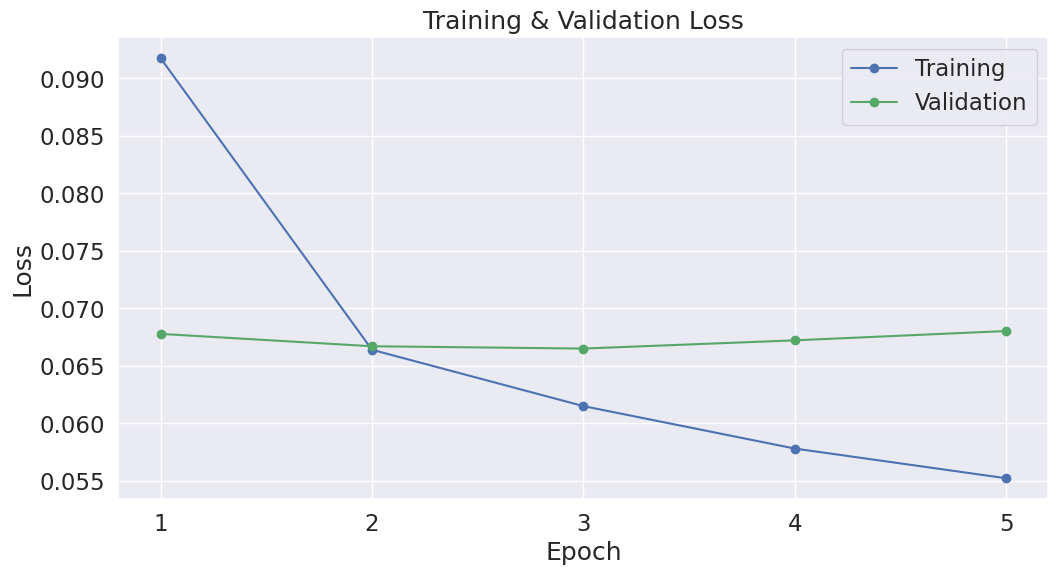

In [32]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

# Display Model Info

In [33]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [34]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Mar 27 16:29 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [82]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “If you like, sir, I shall go to school.”


1: 


2: “A woman has just arrived at Thornfield.”




### YOUR TURN!

These aren't bad at all! Now train the model on your chosen raw text that is roughly comparable in size to pride and prejudice.

There are two things you need to do:

- Draw a figure tracking the training and validation losses as in previous homeworks.

- Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?


> 10 interesting example generations (they are very similar to my training text--Jane Eyre by Charlotte Brontë)

1. “But no! let us be reconciled!” exclaimed Helen.
2. “No, Jane, I am not afraid of you.”
3. “Jane, you have a strange passion. And how is your brain?”
4. not even that of a lady, nor even that of a man; she never married.
5. The door was bolted; the clerk-door was locked. The door was again unclosed.
6. He stopped; his eye met my shoulder: he did not care to look up.
7. “She said she would give you a dinner-bell-fellow,” I observed.
8. I turned my head from St. John when I heard him speak.
9. I would not have liked it: it would not have been advisable.
10. “A woman has just arrived at Thornfield.”